In [7]:
!pip install matplotlib
!pip install tensorflow==2.8.0
!pip install tensorflow-io==0.25.0

  Using cached tensorflow_io-0.25.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached tensorflow_io_gcs_filesystem-0.25.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
Using cached tensorflow_io-0.25.0-cp310-cp310-win_amd64.whl (21.8 MB)
Using cached tensorflow_io_gcs_filesystem-0.25.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.31.0
    Uninstalling tensorflow-io-gcs-filesystem-0.31.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.31.0


In [3]:
!pip install "numpy<2"

   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ----------- ---------------------------- 4.5/15.8 MB 24.4 MB/s eta 0:00:01
   --------------- ------------------------ 6.3/15.8 MB 24.1 MB/s eta 0:00:01
   ---------------------------- ----------- 11.3/15.8 MB 19.6 MB/s eta 0:00:01
   ---------------------------------------  15.7/15.8 MB 20.6 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
!conda list

# packages in environment at C:\Users\foxir\miniconda3\envs\gunshot_tf:
#
# Name                    Version                   Build  Channel
absl-py                   2.1.0                    pypi_0    pypi
asttokens                 3.0.0                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
bzip2                     1.0.8                h2466b09_7    conda-forge
ca-certificates           2024.12.14           h56e8100_0    conda-forge
cachetools                5.5.0                    pypi_0    pypi
certifi                   2024.12.14               pypi_0    pypi
charset-normalizer        3.4.0                    pypi_0    pypi
colorama                  0.4.6                    pypi_0    pypi
comm                      0.2.2                    pypi_0    pypi
contourpy                 1.3.1                    pypi_0    pypi
cudatoolkit               11.2.2              h7d7167e_13    conda-forge
cudnn                     8.1.0.77            

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

In [2]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = os.path.join('belize-data')
train_dir = os.path.join('belize-data', 'Training data')
val_dir = os.path.join('belize-data', 'Validation data')
val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
NEG = os.path.join('belize-data', 'Training data', 'Background')
POS = os.path.join('belize-data', 'Training data', 'Gunshot')
model_save_dir = os.path.join('Users', 'foxir', 'OneDrive', 'Desktop', 'Smart Rock', 'gunshot-detection-models')
outputs_dir = os.path.join('outputs')

In [4]:
def load_wav_8k_mono(filename):
    try:
        file_contents = tf.io.read_file(filename)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        if sample_rate != 8000:
            wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000)
        wav = tf.squeeze(wav, axis=-1)
    except Exception as e:
        print(f"Invalid file: {file_path} - {e}")
    return wav

In [5]:
sample_rate = 8000
mel_spec_length = 32000
frame_length = 256
frame_step = 128
mel_bins = 64
upper_edge = 4000
lower_edge = 0

In [6]:
def preprocess_mel(file_path, label):
    # load wav and make sure length is proper
    try:
        wav = load_wav_8k_mono(file_path)
    except Exception as e:
        print(f"Failed to load wav file at {file_path} - {e}")
    if len(wav) > 32000:
        wav = wav[:mel_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([mel_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")

    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)

    # create the mel filterbank
    spec_bins = frame_length // 2 + 1  # Derived from frame length
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        mel_bins,
        spec_bins,
        sample_rate,
        lower_edge,
        upper_edge,
    )
    print("Mel Filterbank Shape:", mel_filterbank.shape)
    
    # create the mel spectrogram
    mel_spectrogram = tf.matmul(spectrogram, mel_filterbank)
    print("Mel Spectrogram Shape1:", mel_spectrogram.shape)

    # add a dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    print("Mel Spectrogram Shape2:", mel_spectrogram.shape)

    return mel_spectrogram, label

In [8]:
def validate_wav(file_path):
    try:
        audio = tf.audio.decode_wav(tf.io.read_file(file_path))
        return True
    except Exception as e:
        print(f"Invalid file: {file_path} - {e}")
        return False
audio_dir = NEG
for file in os.listdir(audio_dir):
    if not validate_wav(os.path.join(audio_dir, file)):
        print(f"Removing invalid file: {file}")
        os.remove(os.path.join(audio_dir, file))

In [30]:
!pip install spec-augment

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
def apply_specaugment(spectrogram):
    time_mask = np.random.randint(0, spectrogram.shape[1] // 2)
    time_start = np.random.randint(0, spectrogram.shape[1] - time_mask)
    spectrogram[:, time_start:time_start + time_mask] = 0

    freq_mask = np.random.randint(0, spectrogram.shape[0] // 2)
    freq_start = np.random.randint(0, spectrogram.shape[0] - freq_mask)
    spectrogram[freq_start:freq_start + freq_mask, :] = 0

    return spectrogram

In [29]:
def augment_spectrogram_tf(spectrogram, label):
    augmented_spectrogram = tf.py_function(
        func=lambda x: apply_specaugment(x.numpy()),
        inp=[spectrogram],
        Tout=tf.float32,
    )
    return augmented_spectrogram, label

In [9]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
training_data = positives.concatenate(negatives)

In [10]:
data = training_data
data = data.map(preprocess_mel)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [11]:
train = data.take(36)
test = data.skip(36).take(15)
samples, labels = train.as_numpy_iterator().next()

In [10]:
num_batches = sum(1 for _ in data)
take_batches = min(36, num_batches)
print(num_batches)
print(take_batches)

1800
36


In [12]:
for element in data.take(1):
    print(element)

(<tf.Tensor: shape=(16, 249, 64, 1), dtype=float32, numpy=
array([[[[0.02920107],
         [0.033327  ],
         [0.05895142],
         ...,
         [0.58633643],
         [0.6563298 ],
         [0.50548536]],

        [[0.01992422],
         [0.02177682],
         [0.02926566],
         ...,
         [0.53510195],
         [0.5804014 ],
         [0.5208553 ]],

        [[0.01111042],
         [0.01150366],
         [0.00903601],
         ...,
         [0.2578959 ],
         [0.35365897],
         [0.14963026]],

        ...,

        [[0.01748802],
         [0.01725654],
         [0.00454168],
         ...,
         [0.25511825],
         [0.38139784],
         [0.14877008]],

        [[0.02379646],
         [0.02460449],
         [0.01896386],
         ...,
         [0.14322141],
         [0.17918867],
         [0.1687718 ]],

        [[0.02006871],
         [0.02105981],
         [0.01951796],
         ...,
         [0.08606958],
         [0.20766848],
         [0.18454698]]],


 

In [14]:
def take_element_and_label(dataset):
    for batch, labels in dataset.take(1):
        singular_element = batch[0]
        singular_label = labels[0]
    return singular_element, singular_label

In [15]:
def take_element_of_class(dataset, target_label):
    for batch, labels in dataset:
        for i, label in enumerate(labels):
            if label == target_label:
                singular_element = batch[i]
                label = labels[i]
                return singular_element, label
    else:
        print(f"No matching element of label {target_label} found")
    return None, None

1.0
(249, 64, 1)


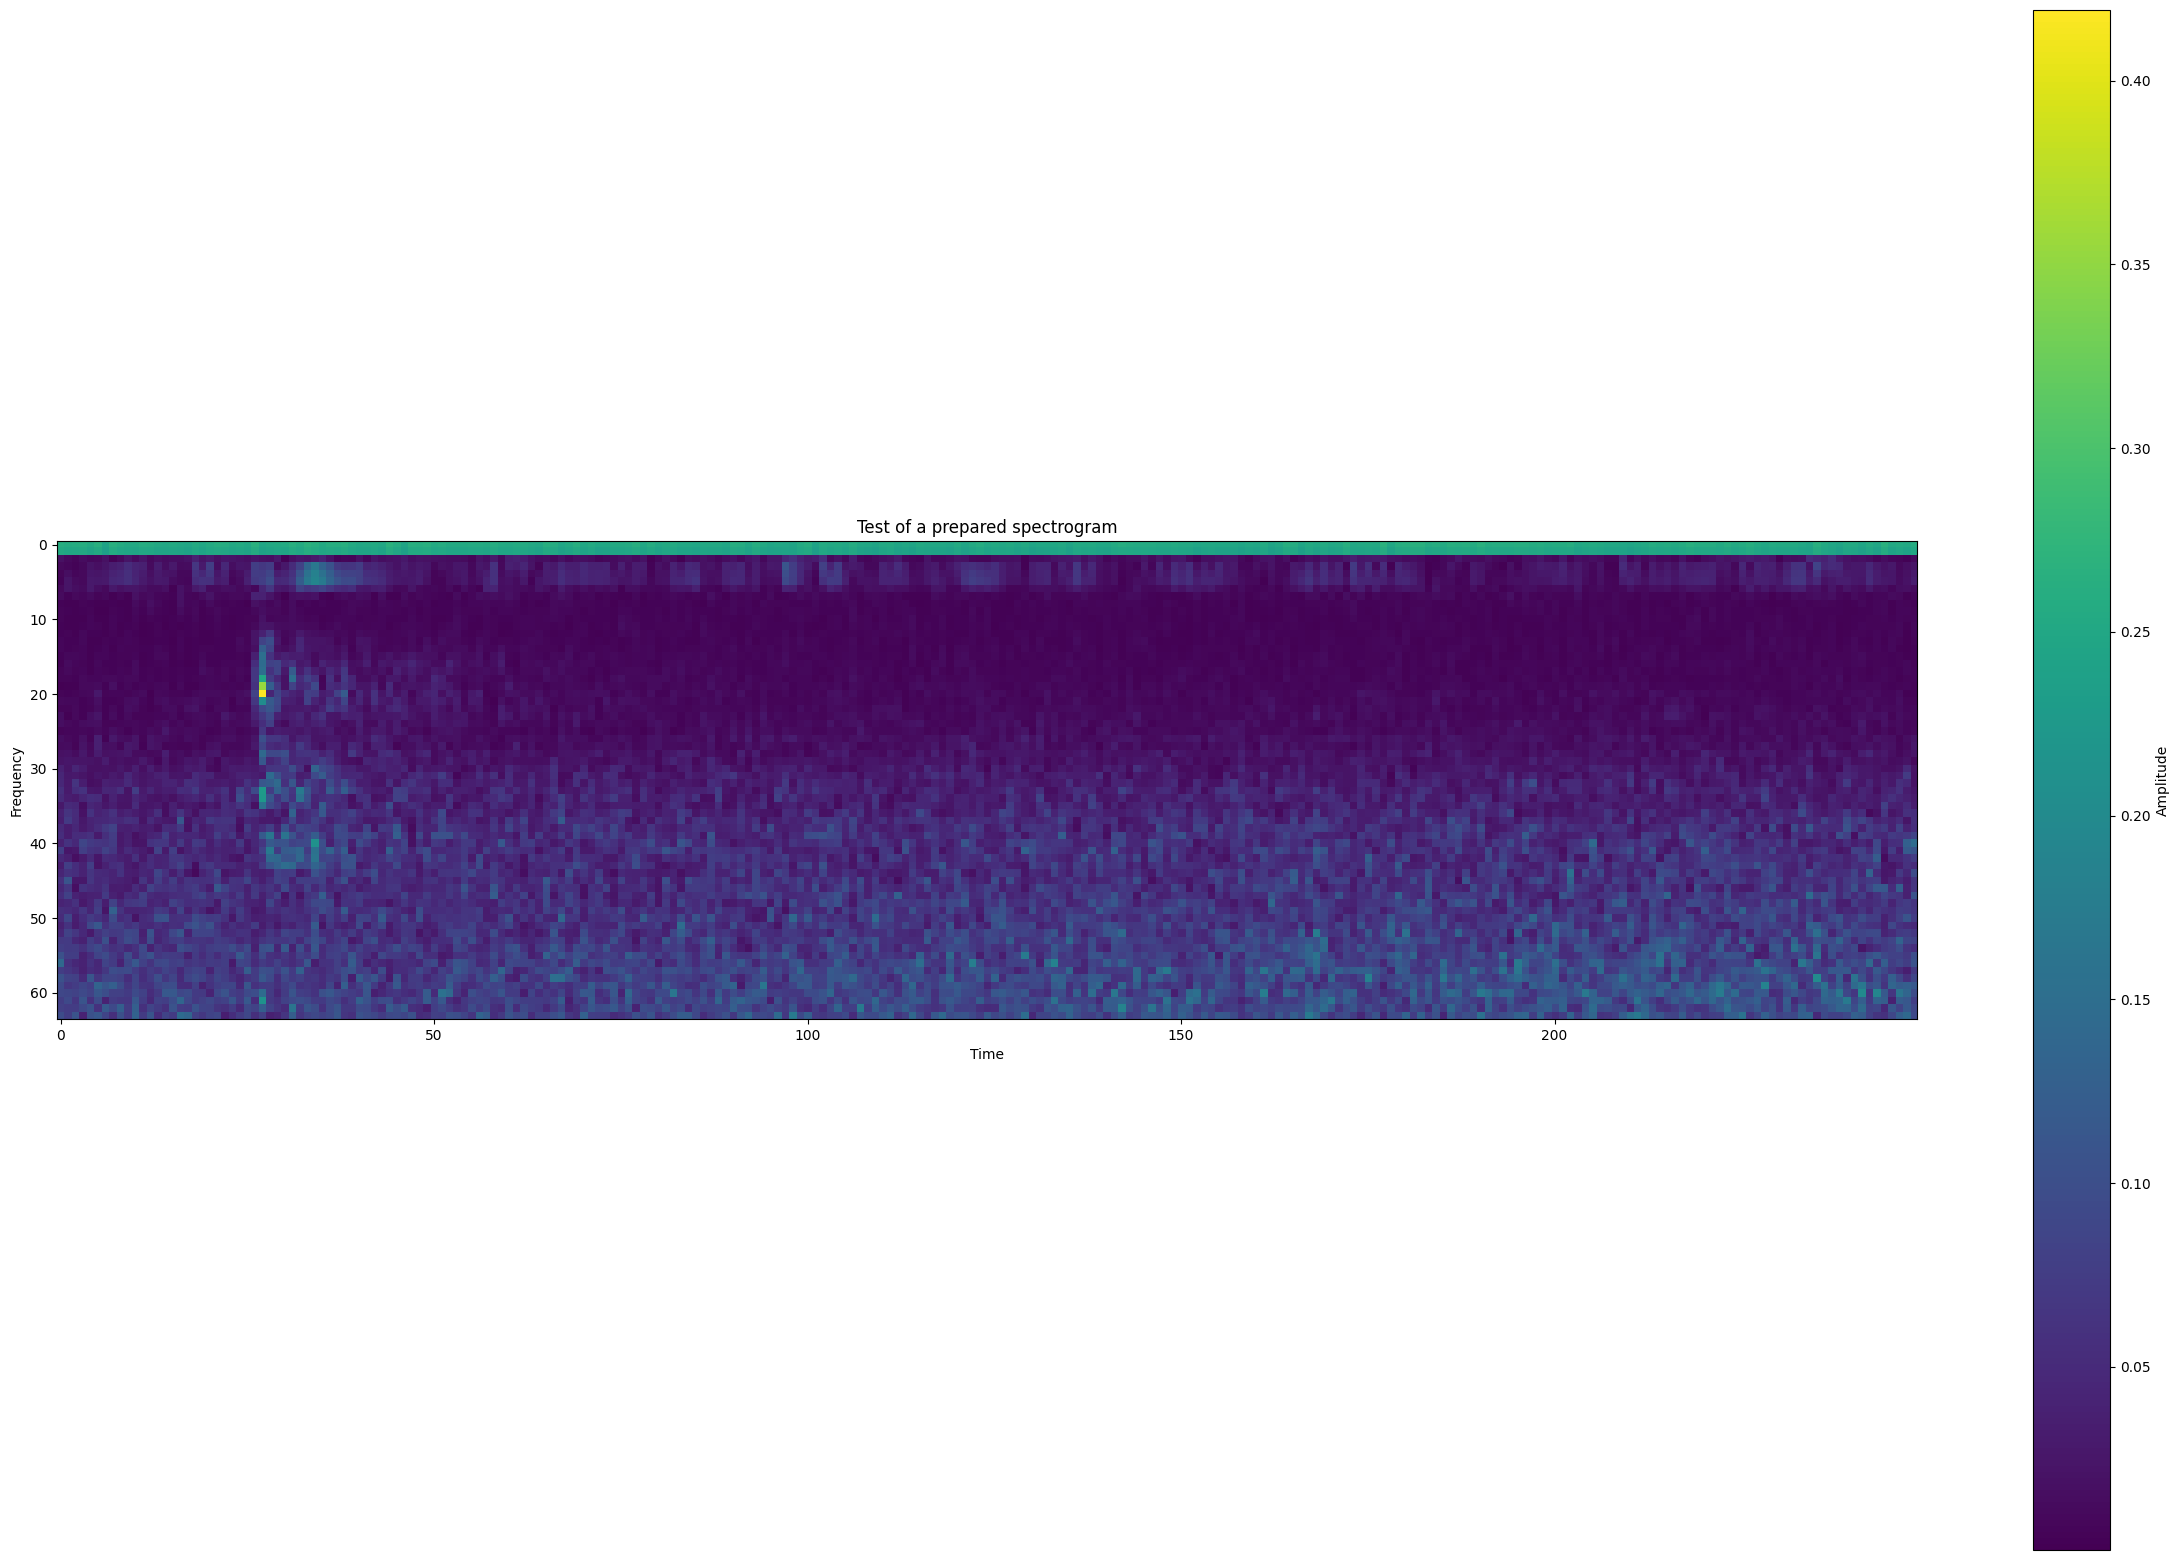

In [16]:
singular_element, label = take_element_of_class(data, 1)
print(label.numpy())
prepared_spectrogram = singular_element
print(prepared_spectrogram.shape)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(prepared_spectrogram)[0])
plt.colorbar(label="Amplitude")
plt.title("Test of a prepared spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

0.0
(249, 64, 1)


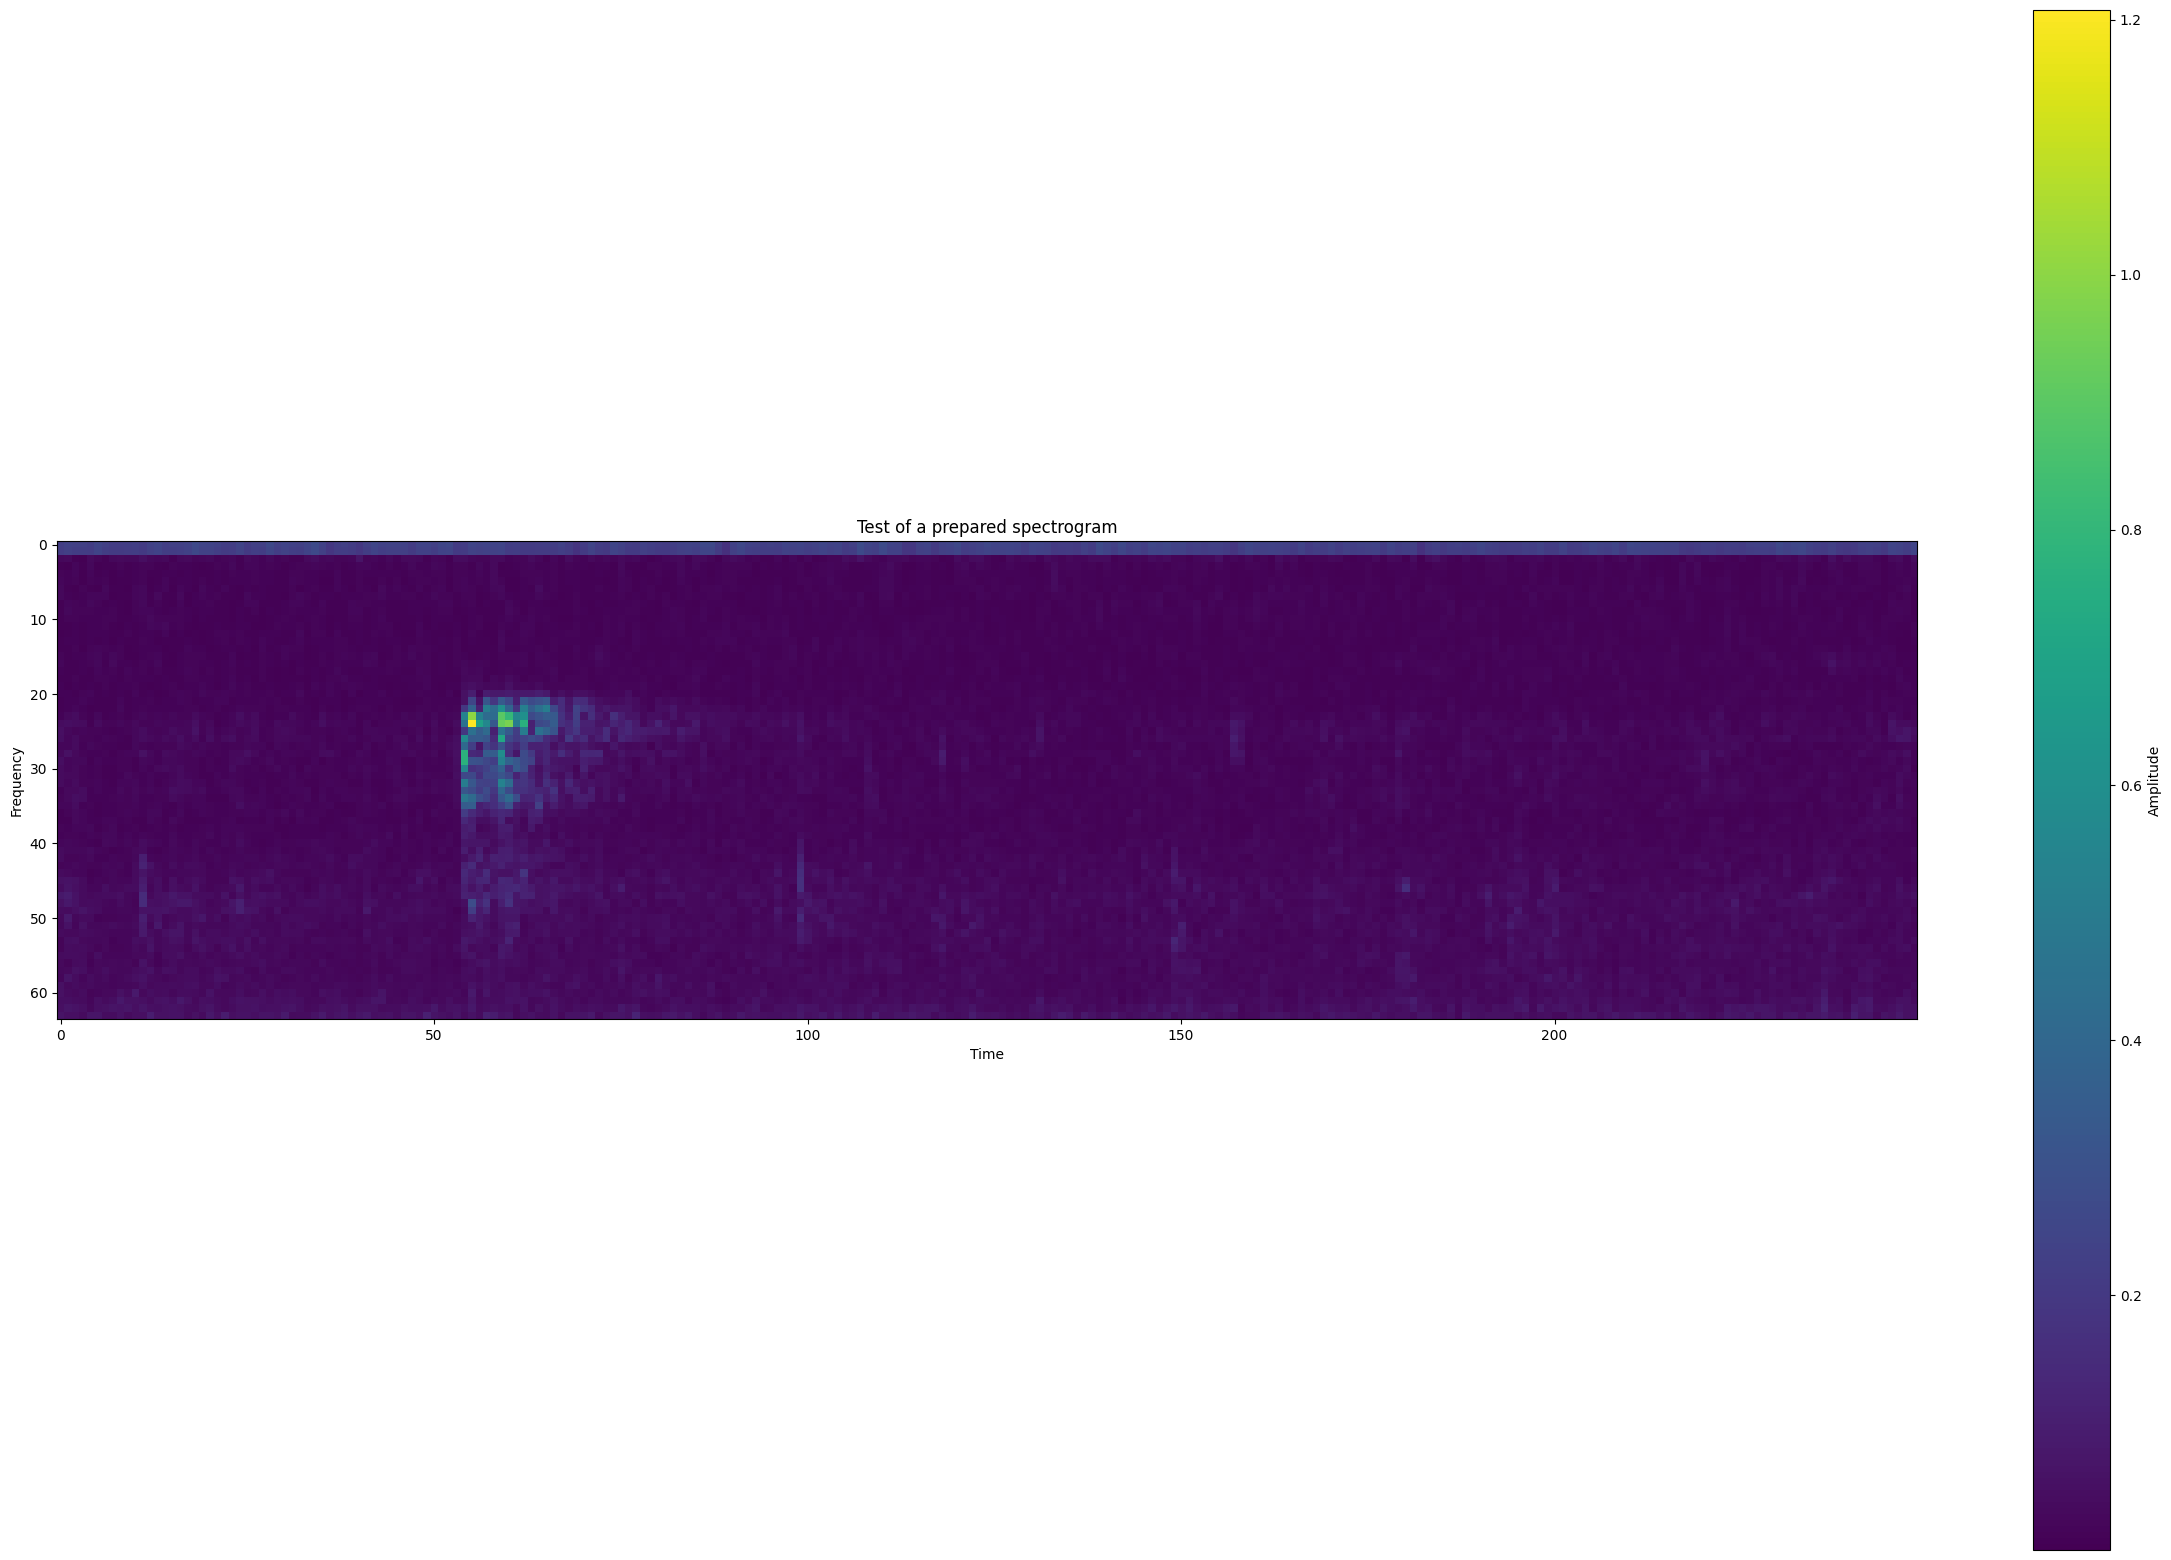

In [20]:
singular_element, singular_label = take_element_and_label(data)
print(singular_label.numpy())
prepared_spectrogram = singular_element
# prepared_spectrogram = tf.squeeze(singular_element, axis=-1)
print(prepared_spectrogram.shape)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(prepared_spectrogram)[0])
plt.colorbar(label="Amplitude")
plt.title("Test of a prepared spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
model=Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.5))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.Accuracy()])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 247, 62, 16)       160       
                                                                 
 conv2d_7 (Conv2D)           (None, 245, 60, 16)       2320      
                                                                 
 dropout_9 (Dropout)         (None, 245, 60, 16)       0         
                                                                 
 flatten_3 (Flatten)         (None, 235200)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               30105728  
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [39]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
36/36 [==============================] - 6s 127ms/step - loss: 0.6567 - recall_2: 0.5654 - precision_2: 0.6533 - val_loss: 0.5309 - val_recall_2: 0.3200 - val_precision_2: 0.7273
Epoch 2/20
36/36 [==============================] - 6s 126ms/step - loss: 0.5782 - recall_2: 0.7664 - precision_2: 0.6977 - val_loss: 0.4332 - val_recall_2: 0.2027 - val_precision_2: 0.8824
Epoch 3/20
36/36 [==============================] - 5s 118ms/step - loss: 0.4449 - recall_2: 0.7773 - precision_2: 0.7897 - val_loss: 0.3020 - val_recall_2: 0.8684 - val_precision_2: 0.8250
Epoch 4/20
36/36 [==============================] - 5s 116ms/step - loss: 0.3823 - recall_2: 0.8182 - precision_2: 0.8340 - val_loss: 0.2946 - val_recall_2: 0.8592 - val_precision_2: 0.8243
Epoch 5/20
36/36 [==============================] - 6s 130ms/step - loss: 0.3749 - recall_2: 0.8490 - precision_2: 0.8387 - val_loss: 0.3421 - val_recall_2: 0.4474 - val_precision_2: 0.9189
Epoch 6/20
36/36 [==============================] 

In [40]:
hist.history

{'loss': [0.6566752195358276,
  0.5782293081283569,
  0.4448704123497009,
  0.38232550024986267,
  0.3748880922794342,
  0.33718550205230713,
  0.2452423870563507,
  0.22833251953125,
  0.2061185985803604,
  0.24480970203876495,
  0.23372681438922882,
  0.2589021325111389,
  0.13143590092658997,
  0.16723236441612244,
  0.0721028596162796,
  0.0649200975894928,
  0.106865294277668,
  0.13311520218849182,
  0.07777702808380127,
  0.17826014757156372],
 'recall_2': [0.5653846263885498,
  0.7664233446121216,
  0.77734375,
  0.8181818127632141,
  0.8489795923233032,
  0.8446969985961914,
  0.9066147804260254,
  0.8947368264198303,
  0.9067164063453674,
  0.9625468254089355,
  0.9272030591964722,
  0.9160584211349487,
  0.9656488299369812,
  0.9583333134651184,
  0.9962825179100037,
  0.9760956168174744,
  0.9813432693481445,
  0.9547169804573059,
  0.9885057210922241,
  0.966292142868042],
 'precision_2': [0.653333306312561,
  0.6976743936538696,
  0.7896825671195984,
  0.8339768052101135,

<function matplotlib.pyplot.show(close=None, block=None)>

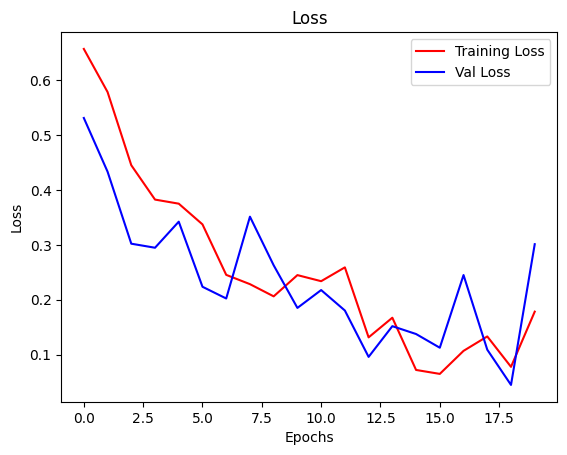

In [41]:
plt.title('Loss')
plt.plot((hist.history['loss']), 'r', label='Training Loss')
plt.plot((hist.history['val_loss']), 'b', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

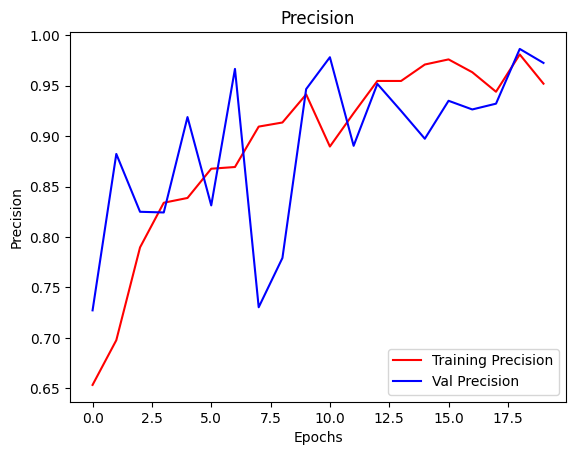

In [42]:
plt.title('Precision')
plt.plot((hist.history['precision_2']), 'r', label='Training Precision')
plt.plot((hist.history['val_precision_2']), 'b', label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

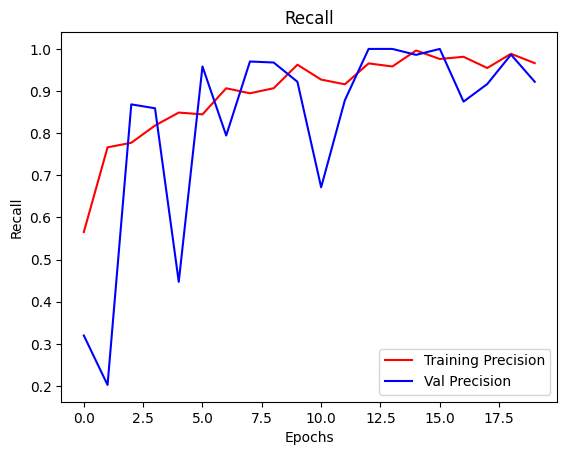

In [43]:
plt.title('Recall')
plt.plot((hist.history['recall_2']), 'r', label='Training Precision')
plt.plot((hist.history['val_recall_2']), 'b', label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show

## 1/3/25, 6:39PM, Belize dataset, no augmentations, 30M parameter old Sequential model, 4 epochs, 36 batches of training data for train, 15 for test
Epoch 1/4
36/36 [==============================] - 5s 86ms/step - loss: 0.9314 - recall: 0.6151 - precision: 0.6653 - val_loss: 0.4731 - val_recall: 0.2143 - val_precision: 0.7895

Epoch 2/4
36/36 [==============================] - 3s 80ms/step - loss: 0.5725 - recall: 0.7538 - precision: 0.6700 - val_loss: 0.4382 - val_recall: 0.6712 - val_precision: 0.6806

Epoch 3/4
36/36 [==============================] - 3s 80ms/step - loss: 0.4679 - recall: 0.8148 - precision: 0.7612 - val_loss: 0.4255 - val_recall: 0.8533 - val_precision: 0.6809

Epoch 4/4
36/36 [==============================] - 3s 80ms/step - loss: 0.3992 - recall: 0.8491 - precision: 0.7979 - val_loss: 0.3711 - val_recall: 0.9189 - val_precision: 0.6939

## 1/3/25, 7:14PM, Belize dataset, no augmentations, 30M parameter old Sequential model, 36 batches of training data for train, 15 for test (PROBABLY OVERFIT)
Epoch 1/20
36/36 [==============================] - 6s 127ms/step - loss: 0.6567 - recall_2: 0.5654 - precision_2: 0.6533 - val_loss: 0.5309 - val_recall_2: 0.3200 - val_precision_2: 0.7273

Epoch 2/20
36/36 [==============================] - 6s 126ms/step - loss: 0.5782 - recall_2: 0.7664 - precision_2: 0.6977 - val_loss: 0.4332 - val_recall_2: 0.2027 - val_precision_2: 0.8824

Epoch 3/20
36/36 [==============================] - 5s 118ms/step - loss: 0.4449 - recall_2: 0.7773 - precision_2: 0.7897 - val_loss: 0.3020 - val_recall_2: 0.8684 - val_precision_2: 0.8250

Epoch 4/20
36/36 [==============================] - 5s 116ms/step - loss: 0.3823 - recall_2: 0.8182 - precision_2: 0.8340 - val_loss: 0.2946 - val_recall_2: 0.8592 - val_precision_2: 0.8243

Epoch 5/20
36/36 [==============================] - 6s 130ms/step - loss: 0.3749 - recall_2: 0.8490 - precision_2: 0.8387 - val_loss: 0.3421 - val_recall_2: 0.4474 - val_precision_2: 0.9189

Epoch 6/20
36/36 [==============================] - 6s 122ms/step - loss: 0.3372 - recall_2: 0.8447 - precision_2: 0.8677 - val_loss: 0.2236 - val_recall_2: 0.9583 - val_precision_2: 0.8313

Epoch 7/20
36/36 [==============================] - 5s 119ms/step - loss: 0.2452 - recall_2: 0.9066 - precision_2: 0.8694 - val_loss: 0.2022 - val_recall_2: 0.7945 - val_precision_2: 0.9667

Epoch 8/20
36/36 [==============================] - 5s 116ms/step - loss: 0.2283 - recall_2: 0.8947 - precision_2: 0.9095 - val_loss: 0.3512 - val_recall_2: 0.9701 - val_precision_2: 0.7303

Epoch 9/20
36/36 [==============================] - 5s 112ms/step - loss: 0.2061 - recall_2: 0.9067 - precision_2: 0.9135 - val_loss: 0.2626 - val_recall_2: 0.9677 - val_precision_2: 0.7792

Epoch 10/20
36/36 [==============================] - 5s 110ms/step - loss: 0.2448 - recall_2: 0.9625 - precision_2: 0.9414 - val_loss: 0.1851 - val_recall_2: 0.9221 - val_precision_2: 0.9467

Epoch 11/20
36/36 [==============================] - 5s 111ms/step - loss: 0.2337 - recall_2: 0.9272 - precision_2: 0.8897 - val_loss: 0.2176 - val_recall_2: 0.6716 - val_precision_2: 0.9783

Epoch 12/20
36/36 [==============================] - 5s 111ms/step - loss: 0.2589 - recall_2: 0.9161 - precision_2: 0.9228 - val_loss: 0.1803 - val_recall_2: 0.8784 - val_precision_2: 0.8904

Epoch 13/20
36/36 [==============================] - 5s 116ms/step - loss: 0.1314 - recall_2: 0.9656 - precision_2: 0.9547 - val_loss: 0.0959 - val_recall_2: 1.0000 - val_precision_2: 0.9518

Epoch 14/20
36/36 [==============================] - 5s 115ms/step - loss: 0.1672 - recall_2: 0.9583 - precision_2: 0.9547 - val_loss: 0.1518 - val_recall_2: 1.0000 - val_precision_2: 0.9250

Epoch 15/20
36/36 [==============================] - 5s 111ms/step - loss: 0.0721 - recall_2: 0.9963 - precision_2: 0.9710 - val_loss: 0.1375 - val_recall_2: 0.9859 - val_precision_2: 0.8974

Epoch 16/20
36/36 [==============================] - 5s 110ms/step - loss: 0.0649 - recall_2: 0.9761 - precision_2: 0.9761 - val_loss: 0.1126 - val_recall_2: 1.0000 - val_precision_2: 0.9351

Epoch 17/20
36/36 [==============================] - 5s 110ms/step - loss: 0.1069 - recall_2: 0.9813 - precision_2: 0.9634 - val_loss: 0.2449 - val_recall_2: 0.8750 - val_precision_2: 0.9265

Epoch 18/20
36/36 [==============================] - 5s 109ms/step - loss: 0.1331 - recall_2: 0.9547 - precision_2: 0.9440 - val_loss: 0.1090 - val_recall_2: 0.9167 - val_precision_2: 0.9322

Epoch 19/20
36/36 [==============================] - 5s 108ms/step - loss: 0.0778 - recall_2: 0.9885 - precision_2: 0.9810 - val_loss: 0.0448 - val_recall_2: 0.9865 - val_precision_2: 0.9865

Epoch 20/20
36/36 [==============================] - 5s 109ms/step - loss: 0.1783 - recall_2: 0.9663 - precision_2: 0.9520 - val_loss: 0.3011 - val_recall_2: 0.9221 - val_precision_2: 0.9726

In [45]:
model.save('1-3-24,Belize-Dataset,20E.keras', 'model_save_dir')